In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/u-data/u.data


In [2]:
print("Assignment 4 done by Aanass nassiri")

Assignment 4 done by Aanass nassiri


In [3]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

In [4]:
np.random.seed(7)
torch.manual_seed(0)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [11]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

In [7]:
movie_ratings = pd.read_csv('/kaggle/input/u-data/u.data', delimiter='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

# Reindex user_id and item_id to be zero-indexed
user_ids = movie_ratings['user_id'].astype('category').cat.codes
item_ids = movie_ratings['item_id'].astype('category').cat.codes
from torch.utils.data import DataLoader, Dataset, random_split

from torch.utils.data import DataLoader, Dataset, random_split

# Define the Dataset class for the MovieLens data
class MovieLensDataset(Dataset):
    def __init__(self, user_ids, item_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.int64)
        self.item_ids = torch.tensor(item_ids, dtype=torch.int64)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.ratings[idx]

# Instantiate the dataset
dataset = MovieLensDataset(movie_ratings['user_id'].values, movie_ratings['item_id'].values, movie_ratings['rating'].values)

# Splitting the dataset into training and testing sets
num_items = len(dataset)
num_train = int(num_items * 0.8)
num_test = num_items - num_train
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Check the first batch from the DataLoader
next(iter(train_loader))

# Update dataset with reindexed user and item IDs
reindexed_dataset = MovieLensDataset(user_ids, item_ids, movie_ratings['rating'].values/5.0)

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(reindexed_dataset, [num_train, num_test])

# Update DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Update model initialization with the new number of unique users and items
num_users = user_ids.max() + 1
num_items = item_ids.max() + 1
#model = AttentionNeuMF(num_users, num_items)

#anass

In [8]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed",
	type=int,
	default=42,
	help="Seed")
parser.add_argument("--lr",
	type=float,
	default=0.001,
	help="learning rate")
parser.add_argument("--dropout",
	type=float,
	default=0.2,
	help="dropout rate")
parser.add_argument("--batch_size",
	type=int,
	default=256,
	help="batch size for training")
parser.add_argument("--epochs",
	type=int,
	default=30,
	help="training epoches")
parser.add_argument("--top_k",
	type=int,
	default=10,
	help="compute metrics@top_k")
parser.add_argument("--factor_num",
	type=int,
	default=32,
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+',
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng",
	type=int,
	default=4,
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test",
	type=int,
	default=100,
	help="Number of negative samples for test set")
parser.add_argument("--out",
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

In [9]:
args=parser.parse_args("")
print(args)
# Define Rating_Dataset Class
class Rating_Dataset(Dataset):
    def __init__(self, user_list, item_list, rating_list):
        super(Rating_Dataset, self).__init__()
        self.user_list = user_list
        self.item_list = item_list
        self.rating_list = rating_list

    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
        user = self.user_list[idx]
        item = self.item_list[idx]
        rating = self.rating_list[idx]

        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(item, dtype=torch.long),
            torch.tensor(rating, dtype=torch.float)
        )

# Define NCF_Data Class
class NCF_Data(object):
    def __init__(self, args, ratings):
        self.ratings = ratings
        self.num_ng = args.num_ng
        self.num_ng_test = args.num_ng_test
        self.batch_size = args.batch_size

        self.preprocess_ratings = self._reindex(self.ratings)

        self.user_pool = set(self.ratings['user_id'].unique())
        self.item_pool = set(self.ratings['item_id'].unique())

        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        self.negatives = self._negative_sampling(self.preprocess_ratings)

    def _reindex(self, ratings):
        user_list = list(ratings['user_id'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}

        item_list = list(ratings['item_id'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}

        ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
        ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
        ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
        return ratings

    def _leave_one_out(self, ratings):
        ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]
        assert train['user_id'].nunique() == test['user_id'].nunique(), 'Not Match Train User with Test User'
        return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

    def _negative_sampling(self, ratings):
        interact_status = (
            ratings.groupby('user_id')['item_id']
            .apply(set)
            .reset_index()
            .rename(columns={'item_id': 'interacted_items'}))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
        return interact_status[['user_id', 'negative_items', 'negative_samples']]

    def get_train_instance(self):
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
        for row in train_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in range(self.num_ng):
                users.append(int(row.user_id))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = Rating_Dataset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def get_test_instance(self):
        users, items, ratings = [], [], []
        test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
        for row in test_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in getattr(row, 'negative_samples'):
                users.append(int(row.user_id))
                items.append(int(i))
                ratings.append(float(0))
        dataset = Rating_Dataset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return DataLoader(dataset, batch_size=self.num_ng_test + 1, shuffle=False, num_workers=2)



# Load and preprocess data
new_dataset_path = '/kaggle/input/u-data/u.data'

ratings = pd.read_csv(new_dataset_path, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

data = NCF_Data(args, ratings)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

Namespace(seed=42, lr=0.001, dropout=0.2, batch_size=256, epochs=30, top_k=10, factor_num=32, layers=[64, 32, 16, 8], num_ng=4, num_ng_test=100, out=True)


/tmp/ipykernel_32/1287732586.py:67: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_32/1287732586.py:73: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

class AttentionNeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=16, layers=[256, 128, 64, 32], dropout=0.3):
        super(AttentionNeuMF, self).__init__()
        self.user_embedding_GMF = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_GMF = nn.Embedding(num_items, embedding_dim)
        self.user_embedding_MLP = nn.Embedding(num_users, layers[0] // 2)
        self.item_embedding_MLP = nn.Embedding(num_items, layers[0] // 2)

        self.MLP_layers = nn.ModuleList()
        mlp_input_size = layers[0]
        for i in range(1, len(layers)):
            self.MLP_layers.append(nn.Linear(mlp_input_size, layers[i]))
            mlp_input_size = layers[i]

        self.attention_layer = nn.Sequential(
            nn.Linear(embedding_dim + layers[-1], layers[-1]),
            nn.Tanh(),
            nn.Dropout(dropout)
        )
        self.output = nn.Linear(layers[-1], 1)
        self.logistic = nn.Sigmoid()

    def forward(self, user, item):
        user_embedding_GMF = self.user_embedding_GMF(user)
        item_embedding_GMF = self.item_embedding_GMF(item)
        gmf_output = user_embedding_GMF * item_embedding_GMF

        user_embedding_MLP = self.user_embedding_MLP(user)
        item_embedding_MLP = self.item_embedding_MLP(item)
        mlp_output = torch.cat((user_embedding_MLP, item_embedding_MLP), dim=-1)

        for layer in self.MLP_layers:
            mlp_output = F.relu(layer(mlp_output))

        combined_features = torch.cat((gmf_output, mlp_output), dim=-1)
        attention_output = self.attention_layer(combined_features)
        logits = self.output(attention_output)
        return self.logistic(logits)

# Reinitialize the model with the enhanced architecture
model = AttentionNeuMF(num_users, num_items)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Added weight decay for regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduler
criterion = nn.BCELoss()
best_hr = 0
list_HR_NeuMFAttention = []
list_NDCG_NeuMFAttention = []
epochs=20
# Enhanced training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    start_time = time.time()

    for user_ids, item_ids, ratings in train_loader:
        user_ids, item_ids, ratings = user_ids.to(torch.long).to(device), item_ids.to(torch.long).to(device), ratings.to(torch.float).to(device)
        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs.squeeze(), ratings)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # Step the learning rate scheduler

    # Evaluation loop
    model.eval()
    test_loss = 0
    HR, NDCG = [], []
    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            user_ids, item_ids, ratings = user_ids.to(torch.long).to(device), item_ids.to(torch.long).to(device), ratings.to(torch.float).to(device)
            outputs = model(user_ids, item_ids)
            loss = criterion(outputs.squeeze(), ratings)
            test_loss += loss.item()
            outputs = outputs.squeeze()
            _, indices = torch.topk(outputs, min(10, outputs.size(0)))
            recommends = torch.take(item_ids, indices).cpu().numpy().tolist()

            ng_item = item_ids[0].item()
            HR.append(hit(ng_item, recommends))
            NDCG.append(ndcg(ng_item, recommends))

    elapsed_time = time.time() - start_time
    avg_hr = np.mean(HR)
    avg_ndcg = np.mean(NDCG)
    list_HR_NeuMFAttention.append(avg_hr)
    list_NDCG_NeuMFAttention.append(avg_ndcg)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {total_loss / len(train_loader)}, HR: {avg_hr:.3f}, NDCG: {avg_ndcg:.3f}, Time: {elapsed_time:.2f}s')

    if avg_hr > best_hr:
        best_hr, best_ndcg, best_epoch = avg_hr, avg_ndcg, epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_attention_neumf.pth')

print(f'Best Epoch: {best_epoch+1}, Best HR: {best_hr:.3f}, Best NDCG: {best_ndcg:.3f}')

Epoch 1/20, Training Loss: 0.40645717476381504, HR: 0.390, NDCG: 0.220, Time: 23.01s
Epoch 2/20, Training Loss: 0.35731578321419943, HR: 0.401, NDCG: 0.224, Time: 22.65s
Epoch 3/20, Training Loss: 0.344681820019271, HR: 0.446, NDCG: 0.250, Time: 22.78s
Epoch 4/20, Training Loss: 0.31938791531463, HR: 0.525, NDCG: 0.289, Time: 23.86s
Epoch 5/20, Training Loss: 0.2934436600568683, HR: 0.549, NDCG: 0.310, Time: 23.38s
Epoch 6/20, Training Loss: 0.2716739330257864, HR: 0.580, NDCG: 0.322, Time: 23.19s
Epoch 7/20, Training Loss: 0.251629156382509, HR: 0.586, NDCG: 0.333, Time: 23.07s
Epoch 8/20, Training Loss: 0.22932766089913764, HR: 0.591, NDCG: 0.337, Time: 23.42s
Epoch 9/20, Training Loss: 0.20908508238404297, HR: 0.599, NDCG: 0.344, Time: 23.65s
Epoch 10/20, Training Loss: 0.19229685149759593, HR: 0.615, NDCG: 0.357, Time: 25.86s
Epoch 11/20, Training Loss: 0.15936910981355712, HR: 0.619, NDCG: 0.358, Time: 26.42s
Epoch 12/20, Training Loss: 0.1441871465176575, HR: 0.621, NDCG: 0.357, 

**This another structure of NeuMF attation based with multi head**

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by num_heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(num_heads * self.head_dim, embed_size)

    def forward(self, values, keys, queries):
        N = queries.shape[0]

        values = values.reshape(N, -1, self.num_heads, self.head_dim)
        keys = keys.reshape(N, -1, self.num_heads, self.head_dim)
        queries = queries.reshape(N, -1, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1/2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, -1, self.num_heads * self.head_dim)
        out = self.fc_out(out)
        return out


import torch
import torch.nn as nn
import torch.nn.functional as F
class AttentionNeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=16, layers=[256, 128, 64, 32], dropout=0.3, num_heads=4):
        super(AttentionNeuMF, self).__init__()
        self.user_embedding_GMF = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_GMF = nn.Embedding(num_items, embedding_dim)
        self.user_embedding_MLP = nn.Embedding(num_users, layers[0] // 2)
        self.item_embedding_MLP = nn.Embedding(num_items, layers[0] // 2)

        self.MLP_layers = nn.ModuleList()
        mlp_input_size = layers[0]
        for i in range(1, len(layers)):
            self.MLP_layers.append(nn.Linear(mlp_input_size, layers[i]))
            mlp_input_size = layers[i]

        self.multihead_attn = MultiHeadAttention(embedding_dim, num_heads)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim + layers[-1], layers[-1]),
            nn.Tanh(),
            nn.Dropout(dropout)
        )
        self.output = nn.Linear(layers[-1], 1)
        self.logistic = nn.Sigmoid()

    def forward(self, user, item):
        user_embedding_GMF = self.user_embedding_GMF(user)
        item_embedding_GMF = self.item_embedding_GMF(item)
        gmf_output = user_embedding_GMF * item_embedding_GMF

        user_embedding_MLP = self.user_embedding_MLP(user)
        item_embedding_MLP = self.item_embedding_MLP(item)
        mlp_output = torch.cat((user_embedding_MLP, item_embedding_MLP), dim=-1)

        for layer in self.MLP_layers:
            mlp_output = F.relu(layer(mlp_output))

        attn_output = self.multihead_attn(gmf_output.unsqueeze(1), gmf_output.unsqueeze(1), gmf_output.unsqueeze(1))
        attn_output = attn_output.squeeze(1)

        combined_features = torch.cat((attn_output, mlp_output), dim=-1)
        fc_output = self.fc_layers(combined_features)
        logits = self.output(fc_output)
        return self.logistic(logits)

    
embedding_dim = 16
layers = [256, 128, 64, 32]
dropout = 0.3
num_heads = 4

model = AttentionNeuMF(num_users, num_items, embedding_dim, layers, dropout, num_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Added weight decay for regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduler
criterion = nn.BCELoss()

best_hr = 0
list_HR_NeuMFMultiHeadAtention = []
list_NDCG_NeuMFMultiHeadAtention = []
epochs = 20

# Enhanced training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    start_time = time.time()

    for user_ids, item_ids, ratings in train_loader:
        user_ids, item_ids, ratings = user_ids.to(device), item_ids.to(device), ratings.to(device)
        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs.squeeze(), ratings)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # Step the learning rate scheduler

    # Evaluation loop
    model.eval()
    test_loss = 0
    HR, NDCG = [], []
    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            user_ids, item_ids, ratings = user_ids.to(device), item_ids.to(device), ratings.to(device)
            outputs = model(user_ids, item_ids)
            loss = criterion(outputs.squeeze(), ratings)
            test_loss += loss.item()
            outputs = outputs.squeeze()
            _, indices = torch.topk(outputs, min(10, outputs.size(0)))
            recommends = torch.take(item_ids, indices).cpu().numpy().tolist()

            ng_item = item_ids[0].item()
            HR.append(hit(ng_item, recommends))
            NDCG.append(ndcg(ng_item, recommends))

    elapsed_time = time.time() - start_time
    avg_hr = np.mean(HR)
    avg_ndcg = np.mean(NDCG)
    list_HR_NeuMFMultiHeadAtention.append(avg_hr)
    list_NDCG_NeuMFMultiHeadAtention.append(avg_ndcg)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {total_loss / len(train_loader):.4f}, HR: {avg_hr:.3f}, NDCG: {avg_ndcg:.3f}, Time: {elapsed_time:.2f}s')

    if avg_hr > best_hr:
        best_hr, best_ndcg, best_epoch = avg_hr, avg_ndcg, epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_attention_neumf.pth')

print(f'Best Epoch: {best_epoch+1}, Best HR: {best_hr:.3f}, Best NDCG: {best_ndcg:.3f}')

Epoch 1/20, Training Loss: 0.4005, HR: 0.397, NDCG: 0.218, Time: 26.68s
Epoch 2/20, Training Loss: 0.3552, HR: 0.402, NDCG: 0.222, Time: 26.94s
Epoch 3/20, Training Loss: 0.3404, HR: 0.485, NDCG: 0.268, Time: 28.83s
Epoch 4/20, Training Loss: 0.3098, HR: 0.537, NDCG: 0.303, Time: 28.57s
Epoch 5/20, Training Loss: 0.2737, HR: 0.590, NDCG: 0.327, Time: 28.65s
Epoch 6/20, Training Loss: 0.2345, HR: 0.615, NDCG: 0.356, Time: 28.43s
Epoch 7/20, Training Loss: 0.2094, HR: 0.639, NDCG: 0.366, Time: 29.22s
Epoch 8/20, Training Loss: 0.1912, HR: 0.639, NDCG: 0.372, Time: 28.81s
Epoch 9/20, Training Loss: 0.1760, HR: 0.635, NDCG: 0.373, Time: 29.97s
Epoch 10/20, Training Loss: 0.1620, HR: 0.634, NDCG: 0.364, Time: 27.98s
Epoch 11/20, Training Loss: 0.1287, HR: 0.620, NDCG: 0.373, Time: 27.74s
Epoch 12/20, Training Loss: 0.1148, HR: 0.609, NDCG: 0.368, Time: 28.29s
Epoch 13/20, Training Loss: 0.1043, HR: 0.620, NDCG: 0.364, Time: 28.39s
Epoch 14/20, Training Loss: 0.0951, HR: 0.615, NDCG: 0.363, 

In [23]:
print("AttentionNeuMF hr",list_HR_NeuMFAttention)
print("AttentionNeuMF ndcg",list_NDCG_NeuMFAttention)
print("multi AttentionNeuMF hr",list_HR_NeuMFMultiHeadAtention)
print("multi AttentionNeuMF ndcg",list_NDCG_NeuMFMultiHeadAtention)

AttentionNeuMF hr [0.3902439024390244, 0.40084835630965004, 0.44644750795334043, 0.5249204665959704, 0.5493107104984093, 0.5800636267232238, 0.5864262990455992, 0.5906680805938495, 0.5991516436903499, 0.6150583244962884, 0.6193001060445387, 0.6214209968186638, 0.6097560975609756, 0.601272534464475, 0.6182396606574762, 0.6118769883351007, 0.6139978791092259, 0.6044538706256628, 0.5959703075291622, 0.6108165429480382]
AttentionNeuMF ndcg [0.22019957512963306, 0.22388945251924122, 0.24963435862371866, 0.2890312130811024, 0.30999196939853785, 0.32229806895066065, 0.33300211447581307, 0.3368724567811963, 0.3442368378426233, 0.35705513481456874, 0.35809615204034495, 0.3573067650844418, 0.35998419287027744, 0.35398340960277863, 0.35998131815415707, 0.35752740073170586, 0.35885239620597303, 0.35488955611068856, 0.34698821959536785, 0.34727600826149907]
multi AttentionNeuMF hr [0.39660657476139977, 0.4019088016967126, 0.48462354188759277, 0.5365853658536586, 0.5896076352067868, 0.61505832449628

**Comparison of the 3 models**:

This graphs compare the two new models with attension meachanism and multi head attention mechanism with the old model NeuMF thay perform better then the older model.
i trained just with 20 epochs with more ephocs the multi head attention NeuMF perform better then NeuMF with attention and with the old one 

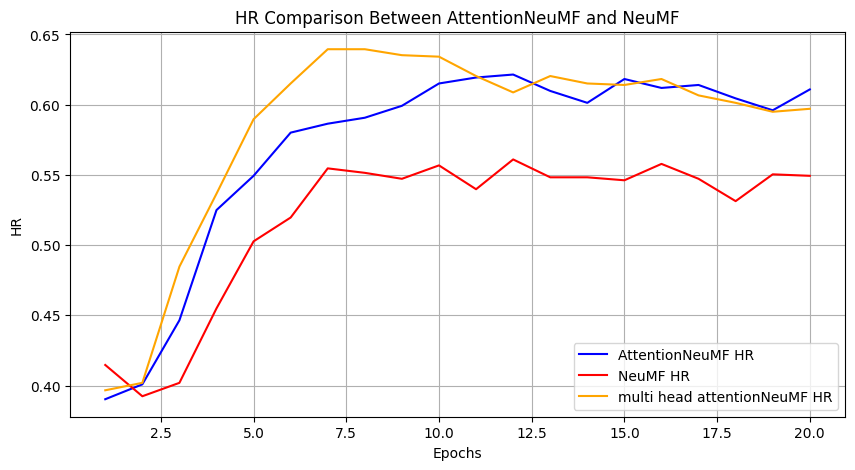

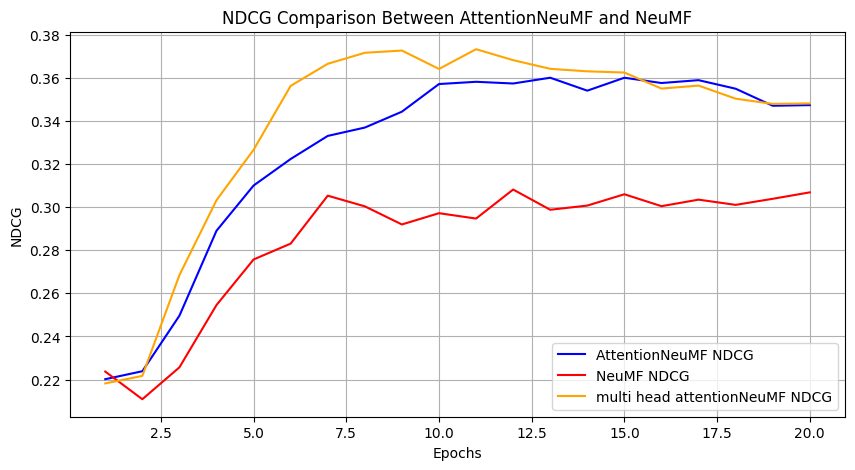

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

hr_attention_neumf = list_HR_NeuMFAttention 
ndcg_attention_neumf = list_NDCG_NeuMFAttention 

#this the performence of old model NeuMF
hr_neumf = [0.4146341463414634, 0.39236479321314954, 0.4019088016967126, 0.45493107104984093, 0.5026511134676565, 0.5196182396606575,
            0.5546129374337222, 0.5514316012725344, 0.5471898197242842, 0.5567338282078473, 0.5397667020148462, 0.5609756097560976,
            0.5482502651113468, 0.5482502651113468,
            0.5461293743372216, 0.5577942735949099, 0.5471898197242842, 0.5312831389183457, 0.5503711558854719, 0.5493107104984093]
ndcg_neumf = [0.22373371810528714, 0.210908862073091, 0.22568665021204865, 0.25458142631066244,
              0.27570735288044945, 0.2830612587829034, 0.3052890167220608, 0.3003440977103102, 
              0.291943805013431, 0.2971683933251404, 0.2946778479839906, 0.30813772442794646, 0.29876002465262647,
              0.30070350519270395, 0.30594371544334303, 0.3004253560926468, 0.3034477224024776, 0.3010273256072969,
              0.3038410090574578, 0.30682776628970354]

# Plotting HR comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs, hr_attention_neumf, label='AttentionNeuMF HR', color='blue')
plt.plot(epochs, hr_neumf, label='NeuMF HR', color='red')
plt.plot(epochs, list_HR_NeuMFMultiHeadAtention, label='multi head attentionNeuMF HR', color='orange')

plt.xlabel('Epochs')
plt.ylabel('HR')
plt.title('HR Comparison Between AttentionNeuMF and NeuMF')
plt.legend()
plt.grid(True)
plt.show()

# Plotting NDCG comparison
plt.figure(figsize=(10, 5))
plt.plot(epochs, ndcg_attention_neumf, label='AttentionNeuMF NDCG', color='blue')
plt.plot(epochs, ndcg_neumf, label='NeuMF NDCG', color='red')
plt.plot(epochs, list_NDCG_NeuMFMultiHeadAtention, label='multi head attentionNeuMF NDCG', color='orange')

plt.xlabel('Epochs')
plt.ylabel('NDCG')
plt.title('NDCG Comparison Between AttentionNeuMF and NeuMF')
plt.legend()
plt.grid(True)
plt.show()


***Hear this graphs compare the two enhanced models with Attention mechanism***

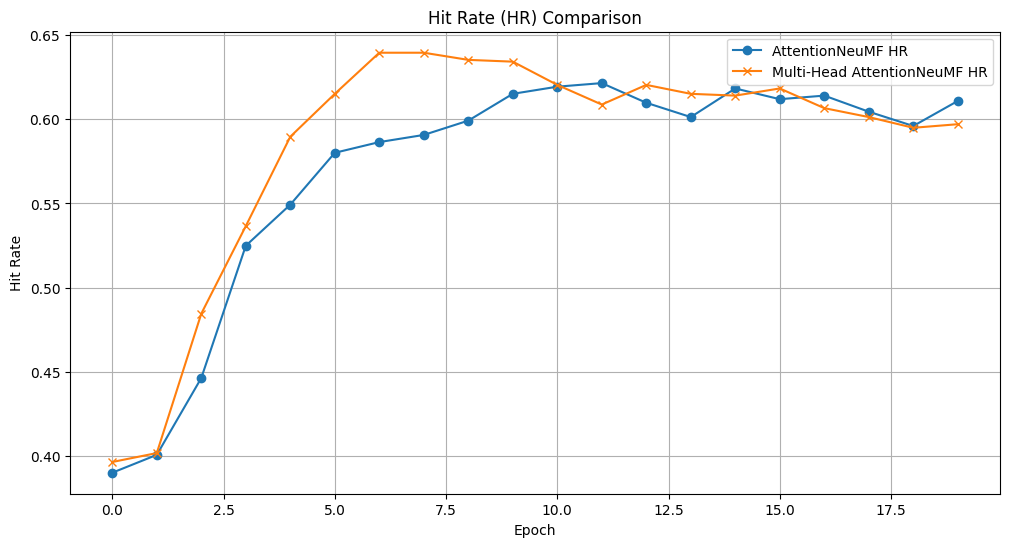

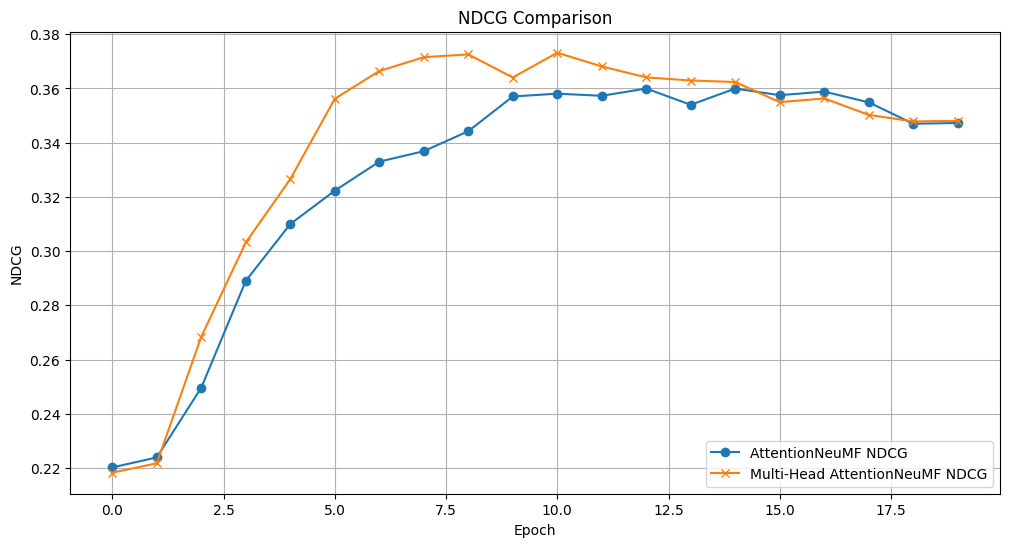

In [25]:
import matplotlib.pyplot as plt

# AttentionNeuMF Performance
hr_attention = list_HR_NeuMFAttention
ndcg_attention = list_NDCG_NeuMFAttention

# Multi-Head AttentionNeuMF Performance
hr_multihead = list_HR_NeuMFMultiHeadAtention
ndcg_multihead = list_NDCG_NeuMFMultiHeadAtention
# Plot HR
plt.figure(figsize=(12, 6))
plt.plot(hr_attention, label='AttentionNeuMF HR', marker='o')
plt.plot(hr_multihead, label='Multi-Head AttentionNeuMF HR', marker='x')
plt.title('Hit Rate (HR) Comparison')
plt.xlabel('Epoch')
plt.ylabel('Hit Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot NDCG
plt.figure(figsize=(12, 6))
plt.plot(ndcg_attention, label='AttentionNeuMF NDCG', marker='o')
plt.plot(ndcg_multihead, label='Multi-Head AttentionNeuMF NDCG', marker='x')
plt.title('NDCG Comparison')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.legend()
plt.grid(True)
plt.show()